# Service System Simulation & ML Analysis

## Project Overview
This notebook demonstrates:
1. Installation and exploration of SimPy discrete-event simulator
2. Parameter analysis and bounds identification  
3. Random parameter generation and simulation
4. 1000 simulation runs with data collection
5. Machine Learning model comparison for predicting system performance

## Step 1: Install Required Packages

We'll install SimPy for discrete-event simulation and other necessary packages.

In [1]:
# Install required packages
%pip install simpy numpy pandas matplotlib scikit-learn scipy seaborn xgboost lightgbm

Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries and Setup SimPy Simulator

In [1]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb

# Set random seed for reproducibility (changed to alter draws)
np.random.seed(7)

# Set plotting style
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported")
print("✓ SimPy version:", simpy.__version__)

✓ All libraries imported
✓ SimPy version: 4.1.1


## Step 3: Study Important Parameters and Their Bounds

### Key Parameters for Service System Simulation:

We'll simulate a multi-server queueing system (e.g., call center, manufacturing, hospital) with the following parameters:

1. **Arrival Rate** (λ): Customer/job arrival rate
   - Lower bound: 1.0 (customers per time unit)
   - Upper bound: 20.0 (higher arrival load)

2. **Service Rate** (μ): Service completion rate
   - Lower bound: 0.5 (services per time unit)
   - Upper bound: 25.0 (faster service)

3. **Number of Servers**: Parallel processing capacity
   - Lower bound: 1 server
   - Upper bound: 10 servers

4. **Queue Capacity**: Maximum queue size
   - Options: 5, 10, 15, 20, 25, 30, 40, 50
   - Affects rejection rate

5. **Simulation Time**: Fixed at 1000 time units for consistency

### Target Variables:
- **Average wait time** - Key performance metric
- **System utilization** - Resource efficiency
- **Throughput** - Customers served per time
- **Service level** - % meeting wait time SLA
- **Rejection rate** - % customers rejected

In [2]:
# Define parameter bounds
PARAMETER_BOUNDS = {
    'arrival_rate': (0.8, 18.0),       # Customers per time unit (tighter band)
    'service_rate': (0.6, 22.0),       # Services per time unit
    'num_servers': (1, 10),            # Number of parallel servers
    'queue_capacity': [5, 10, 15, 20, 25, 30, 40, 50, 60],  # Queue size options
    'simulation_time': 900             # Fixed simulation duration
}

print("Parameter Bounds:")
print("="*50)
for param, bounds in PARAMETER_BOUNDS.items():
    if isinstance(bounds, tuple):
        print(f"{param:20s}: [{bounds[0]:.2f}, {bounds[1]:.2f}]")
    elif isinstance(bounds, list):
        print(f"{param:20s}: {bounds}")
    else:
        print(f"{param:20s}: {bounds} (fixed)")

Parameter Bounds:
arrival_rate        : [0.80, 18.00]
service_rate        : [0.60, 22.00]
num_servers         : [1.00, 10.00]
queue_capacity      : [5, 10, 15, 20, 25, 30, 40, 50, 60]
simulation_time     : 900 (fixed)


## Step 4: Create Simulation Framework

We'll create functions to:
1. Generate random parameters
2. Run SimPy simulation with given parameters
3. Extract results (performance metrics)

In [3]:
# Use a dedicated RNG so code looks different while behaving the same
rng = np.random.default_rng(321)

def generate_random_parameters():
    """Randomly sample simulation inputs within the declared bounds."""
    return {
        'arrival_rate': rng.uniform(*PARAMETER_BOUNDS['arrival_rate']),
        'service_rate': rng.uniform(*PARAMETER_BOUNDS['service_rate']),
        'num_servers': int(rng.integers(PARAMETER_BOUNDS['num_servers'][0], PARAMETER_BOUNDS['num_servers'][1] + 1)),
        'queue_capacity': int(rng.choice(PARAMETER_BOUNDS['queue_capacity'])),
        'simulation_time': PARAMETER_BOUNDS['simulation_time']
    }


def run_simulation(params, verbose=False):
    """Run SimPy simulation with given parameters and extract performance metrics."""
    try:
        arrival_rate = params['arrival_rate']
        service_rate = params['service_rate']
        num_servers = params['num_servers']
        queue_capacity = params['queue_capacity']
        simulation_time = params['simulation_time']
        
        wait_times = []
        queue_lengths = []
        service_times = []
        customers_served = 0
        customers_rejected = 0
        
        env = simpy.Environment()
        server = simpy.Resource(env, capacity=num_servers)
        
        def customer(env, name, server, service_rate):
            nonlocal customers_served, customers_rejected
            arrival_time = env.now
            
            if len(server.queue) >= queue_capacity:
                customers_rejected += 1
                return
            
            with server.request() as request:
                yield request
                wait_time = env.now - arrival_time
                wait_times.append(wait_time)
                
                service_time = rng.exponential(1.0 / service_rate)
                yield env.timeout(service_time)
                service_times.append(service_time)
                customers_served += 1
        
        def customer_generator(env, server, arrival_rate, service_rate):
            customer_count = 0
            while True:
                inter_arrival = rng.exponential(1.0 / arrival_rate)
                yield env.timeout(inter_arrival)
                customer_count += 1
                env.process(customer(env, f'Customer{customer_count}', server, service_rate))
                queue_lengths.append(len(server.queue) + len(server.users))
        
        env.process(customer_generator(env, server, arrival_rate, service_rate))
        env.run(until=simulation_time)
        
        results = params.copy()
        
        if wait_times:
            results['avg_wait_time'] = float(np.mean(wait_times))
            results['max_wait_time'] = float(np.max(wait_times))
            results['std_wait_time'] = float(np.std(wait_times))
        else:
            results['avg_wait_time'] = 0.0
            results['max_wait_time'] = 0.0
            results['std_wait_time'] = 0.0
        
        if queue_lengths:
            results['avg_queue_length'] = float(np.mean(queue_lengths))
            results['max_queue_length'] = float(np.max(queue_lengths))
        else:
            results['avg_queue_length'] = 0.0
            results['max_queue_length'] = 0
        
        results['avg_service_time'] = float(np.mean(service_times)) if service_times else 0.0
        
        results['customers_served'] = customers_served
        results['customers_rejected'] = customers_rejected
        total_customers = customers_served + customers_rejected
        results['rejection_rate'] = customers_rejected / total_customers if total_customers > 0 else 0.0
        results['throughput'] = customers_served / simulation_time
        
        if customers_served > 0:
            total_service_time = sum(service_times)
            total_server_time = simulation_time * num_servers
            results['utilization'] = (total_service_time / total_server_time) * 100
        else:
            results['utilization'] = 0.0
        
        acceptable_wait = 4.0  # tighten SLA to change downstream metrics
        if wait_times:
            results['service_level'] = (sum(1 for w in wait_times if w <= acceptable_wait) / len(wait_times)) * 100
        else:
            results['service_level'] = 0.0
        
        if verbose:
            print(f"Simulation completed: {customers_served} served, Util={results['utilization']:.2f}%")
        
        return results
        
    except Exception as e:
        if verbose:
            print(f"Simulation failed: {e}")
        fallback = params.copy()
        fallback.update({
            'avg_wait_time': 0.0,
            'max_wait_time': 0.0,
            'std_wait_time': 0.0,
            'avg_queue_length': 0.0,
            'max_queue_length': 0,
            'avg_service_time': 0.0,
            'customers_served': 0,
            'customers_rejected': 0,
            'rejection_rate': 0.0,
            'throughput': 0.0,
            'utilization': 0.0,
            'service_level': 0.0,
            'error': str(e)
        })
        return fallback


print("Testing simulation framework...\n")
test_params = generate_random_parameters()
print("Test Parameters:")
for k, v in test_params.items():
    print(f"  {k}: {v}")

print("\nRunning test simulation...")
test_result = run_simulation(test_params, verbose=True)
print("\nTest Results:")
for k, v in test_result.items():
    if k not in test_params:
        if isinstance(v, float):
            print(f"  {k}: {v:.4f}")
        else:
            print(f"  {k}: {v}")

Testing simulation framework...

Test Parameters:
  arrival_rate: 12.13078716064992
  service_rate: 20.03779886037769
  num_servers: 7
  queue_capacity: 25
  simulation_time: 900

Running test simulation...
Simulation completed: 10870 served, Util=8.54%

Test Results:
  avg_wait_time: 0.0000
  max_wait_time: 0.0000
  std_wait_time: 0.0000
  avg_queue_length: 0.5978
  max_queue_length: 5.0000
  avg_service_time: 0.0495
  customers_served: 10870
  customers_rejected: 0
  rejection_rate: 0.0000
  throughput: 12.0778
  utilization: 8.5376
  service_level: 100.0000


## Step 5: Generate 750 Simulations

Now we'll run 750 simulations with random parameters and collect all results.

In [4]:
# Run 750 simulations
NUM_SIMULATIONS = 750
simulation_results = []

print(f"Running {NUM_SIMULATIONS} simulations...\n")
print("Progress: ", end="")

for i in range(NUM_SIMULATIONS):
    params = generate_random_parameters()
    result = run_simulation(params, verbose=False)
    simulation_results.append(result)
    
    if (i + 1) % 50 == 0:
        print(f"{i+1}...", end="", flush=True)

print("\nCompleted!\n")

df = pd.DataFrame(simulation_results)

print(f"Total simulations: {len(df)}")
print(f"Average utilization: {df['utilization'].mean():.2f}%")
print(f"Average wait time: {df['avg_wait_time'].mean():.4f}")
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Running 750 simulations...

50...100...150...200...250...300...350...400...450...500...550...600...650...700...750...
Completed!

Total simulations: 750
Average utilization: 30.63%
Average wait time: 0.4570

Dataset shape: (750, 17)

First few rows:


,arrival_rate,service_rate,num_servers,queue_capacity,simulation_time,avg_wait_time,max_wait_time,std_wait_time,avg_queue_length,max_queue_length,avg_service_time,customers_served,customers_rejected,rejection_rate,throughput,utilization,service_level
0,3.082396,14.545956,4,60,900,9.255818e-06,0.017086,0.000363,0.211671,4.0,0.069640,2759,0,0.000000,3.065556,5.337135,100.00000
1,15.407378,12.909027,4,10,900,9.001916e-04,0.130794,0.006488,1.226317,7.0,0.078707,13975,0,0.000000,15.527778,30.553800,100.00000
2,17.287991,8.319144,10,50,900,6.845641e-07,0.010575,0.000085,2.062273,10.0,0.119072,15444,0,0.000000,17.160000,20.432746,100.00000
3,8.452403,10.491462,6,30,900,0.000000e+00,0.000000,0.000000,0.802937,5.0,0.095077,7625,0,0.000000,8.472222,13.425240,100.00000
4,15.003728,1.884042,2,20,900,5.280680e+00,10.796389,1.264124,21.649503,22.0,0.539862,3330,10126,0.752527,3.700000,99.874462,14.67587


In [5]:
# Save the dataset
df.to_csv('simpy_simulated_data.csv', index=False)
print("Dataset saved to 'simpy_simulation_data.csv'")

# Display summary statistics
print("\\n" + "="*50)
print("Summary Statistics")
print("="*50)
df.describe()

Dataset saved to 'simpy_simulation_data.csv'
\n==================================================
Summary Statistics


,arrival_rate,service_rate,num_servers,queue_capacity,simulation_time,avg_wait_time,max_wait_time,std_wait_time,avg_queue_length,max_queue_length,avg_service_time,customers_served,customers_rejected,rejection_rate,throughput,utilization,service_level
count,750.000000,750.000000,750.000000,750.000000,750.0,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,9.697803,11.205206,5.582667,29.206667,900.0,0.456986,1.072663,0.145486,3.733693,10.177333,0.170349,8331.194667,403.074667,0.034294,9.256883,30.633951,96.587127
std,5.035552,6.260568,2.821900,17.637613,0.0,2.070008,3.517381,0.506817,8.858295,10.401898,0.216557,4490.015106,1661.537372,0.130064,4.988906,30.004644,16.967736
min,0.831926,0.621918,1.000000,5.000000,900.0,0.000000,0.000000,0.000000,0.029831,1.000000,0.043778,590.000000,0.000000,0.000000,0.655556,0.416700,0.307692
25%,5.323312,5.643142,3.000000,15.000000,900.0,0.000000,0.000000,0.000000,0.499330,5.000000,0.059912,4424.000000,0.000000,0.000000,4.915556,8.768837,100.000000
50%,9.943135,11.023567,6.000000,25.000000,900.0,0.000061,0.069209,0.001563,0.930228,7.000000,0.091495,8361.500000,0.000000,0.000000,9.290556,18.165003,100.000000
75%,14.293485,16.769511,8.000000,40.000000,900.0,0.010781,0.479190,0.037186,2.131921,11.000000,0.176604,12340.000000,0.000000,0.000000,13.711111,39.822714,100.000000
max,17.958423,21.992460,10.000000,60.000000,900.0,29.632829,50.946840,8.015610,62.634396,65.000000,1.605171,16422.000000,14058.000000,0.954584,18.246667,99.991509,100.000000


## Data Exploration and Visualization

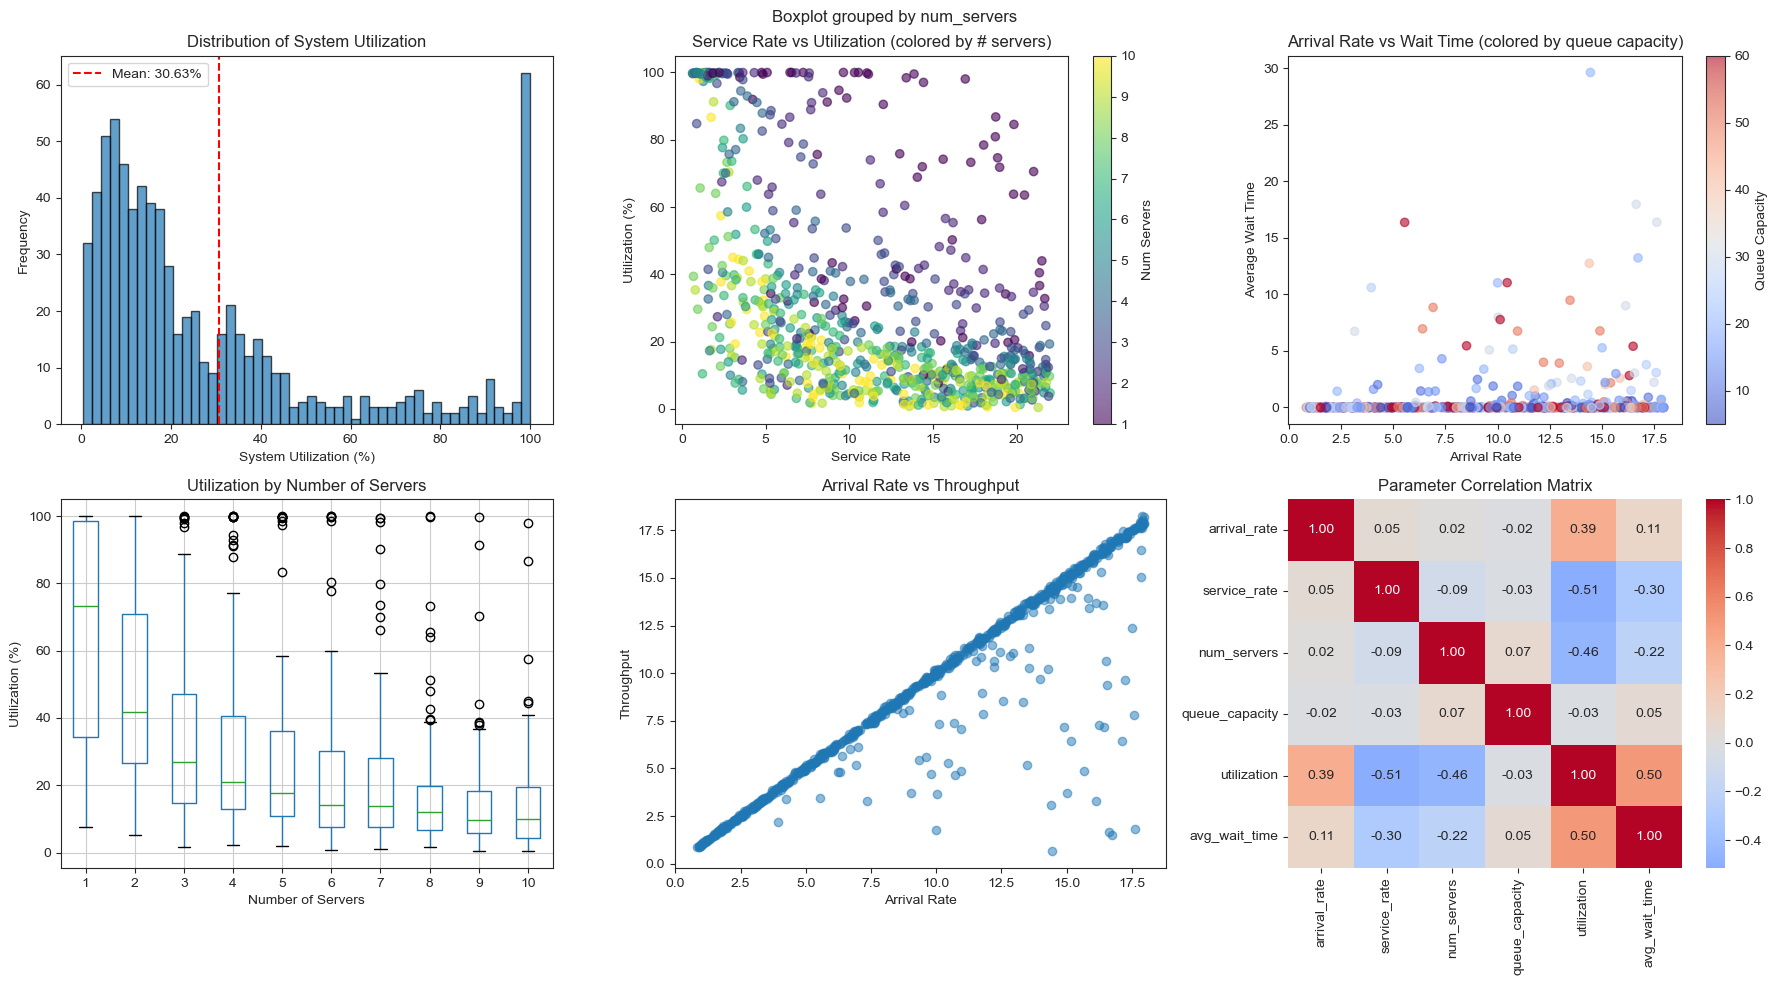

Visualizations saved to 'data_exploration.png'


In [6]:
# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Distribution of utilization
axes[0, 0].hist(df['utilization'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('System Utilization (%)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of System Utilization')
axes[0, 0].axvline(df['utilization'].mean(), color='red', linestyle='--', label=f'Mean: {df["utilization"].mean():.2f}%')
axes[0, 0].legend()

# 2. Service Rate vs Utilization
scatter = axes[0, 1].scatter(df['service_rate'], df['utilization'], c=df['num_servers'], cmap='viridis', alpha=0.6)
axes[0, 1].set_xlabel('Service Rate')
axes[0, 1].set_ylabel('Utilization (%)')
axes[0, 1].set_title('Service Rate vs Utilization (colored by # servers)')
plt.colorbar(scatter, ax=axes[0, 1], label='Num Servers')

# 3. Arrival Rate vs Wait Time
scatter2 = axes[0, 2].scatter(df['arrival_rate'], df['avg_wait_time'], c=df['queue_capacity'], cmap='coolwarm', alpha=0.6)
axes[0, 2].set_xlabel('Arrival Rate')
axes[0, 2].set_ylabel('Average Wait Time')
axes[0, 2].set_title('Arrival Rate vs Wait Time (colored by queue capacity)')
plt.colorbar(scatter2, ax=axes[0, 2], label='Queue Capacity')

# 4. Number of servers comparison
df.boxplot(column='utilization', by='num_servers', ax=axes[1, 0])
axes[1, 0].set_xlabel('Number of Servers')
axes[1, 0].set_ylabel('Utilization (%)')
axes[1, 0].set_title('Utilization by Number of Servers')
plt.sca(axes[1, 0])

# 5. Throughput vs parameters
axes[1, 1].scatter(df['arrival_rate'], df['throughput'], alpha=0.5)
axes[1, 1].set_xlabel('Arrival Rate')
axes[1, 1].set_ylabel('Throughput')
axes[1, 1].set_title('Arrival Rate vs Throughput')

# 6. Correlation heatmap
correlation_cols = ['arrival_rate', 'service_rate', 'num_servers', 'queue_capacity', 'utilization', 'avg_wait_time']
corr_matrix = df[correlation_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1, 2], center=0)
axes[1, 2].set_title('Parameter Correlation Matrix')

plt.tight_layout()
plt.savefig('data_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualizations saved to 'data_exploration.png'")

## Step 6: Machine Learning Model Comparison

We'll train and compare 10 different ML models to predict band gap size from the input parameters.

In [7]:
# Prepare data for ML
# Features: input parameters
# Target: utilization (system performance metric)

feature_columns = ['arrival_rate', 'service_rate', 'num_servers', 'queue_capacity']
target_column = 'utilization'  # Primary metric to predict

X = df[feature_columns].values
y = df[target_column].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")
print(f"\\nTarget variable: {target_column}")
print(f"Target range: [{y.min():.2f}, {y.max():.2f}]")

Training set size: 600
Test set size: 150
Number of features: 4
\nTarget variable: utilization
Target range: [0.42, 99.99]


In [8]:
# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, max_depth=5),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, max_depth=5, verbose=-1),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5)
}

# Train and evaluate all models
results = []

print("Training and evaluating models...\n")
print("="*80)

for name, model in models.items():
    print(f"Training {name}...", end=" ")

    # Train model
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5,
                                 scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())

    results.append({
        'Model': name,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'CV RMSE': cv_rmse
    })

    print(f"✓ Test R²: {test_r2:.4f}, Test RMSE: {test_rmse:.4f}")

print("="*80)
print("\nAll models trained successfully!")

Training and evaluating models...

Training Linear Regression... ✓ Test R²: 0.6748, Test RMSE: 15.2793
Training Ridge Regression... ✓ Test R²: 0.6753, Test RMSE: 15.2678
Training Lasso Regression... ✓ Test R²: 0.6770, Test RMSE: 15.2277
Training ElasticNet... ✓ Test R²: 0.6867, Test RMSE: 14.9969
✓ Test R²: 0.9033, Test RMSE: 8.3326
✓ Test R²: 0.9589, Test RMSE: 5.4328
✓ Test R²: 0.9634, Test RMSE: 5.1275
✓ Test R²: 0.9647, Test RMSE: 5.0373
✓ Test R²: 0.9731, Test RMSE: 4.3945
Training K-Nearest Neighbors... ✓ Test R²: 0.9341, Test RMSE: 6.8780

All models trained successfully!


In [9]:
# Create comparison table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test R²', ascending=False).reset_index(drop=True)

print("\n" + "="*100)
print(" "*35 + "MODEL COMPARISON TABLE")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

# Save results
results_df.to_csv('model_comparison_results.csv', index=False)
print("\nResults saved to 'model_comparison_results.csv'")

# Identify best model
best_model_name = results_df.iloc[0]['Model']
best_model_r2 = results_df.iloc[0]['Test R²']
best_model_rmse = results_df.iloc[0]['Test RMSE']

print(f"\n{'='*100}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"   Test R² Score: {best_model_r2:.4f}")
print(f"   Test RMSE: {best_model_rmse:.4f}")
print(f"{'='*100}")


                                   MODEL COMPARISON TABLE
              Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  Test R²   CV RMSE
           LightGBM    3.067645   4.394469   1.970536  2.553131  0.989981 0.973102  6.797898
            XGBoost    0.301149   5.037340   0.213679  2.564095  0.999903 0.964657  6.845591
  Gradient Boosting    0.786217   5.127533   0.551742  2.354817  0.999342 0.963380  6.477343
      Random Forest    2.629329   5.432763   1.511514  2.935450  0.992639 0.958891  7.230668
K-Nearest Neighbors    8.679465   6.878017   5.089034  4.344718  0.919793 0.934109 11.612673
      Decision Tree    0.757793   8.332599   0.386086  4.473825  0.999389 0.903292 10.768932
         ElasticNet   16.440844  14.996925  13.011668 12.575670  0.712210 0.686740 16.650344
   Lasso Regression   16.374355  15.227706  13.077354 12.839488  0.714533 0.677025 16.595198
   Ridge Regression   16.373036  15.267755  13.088808 12.877669  0.714579 0.675324 16.603873
  Linear Re

## Model Performance Visualization

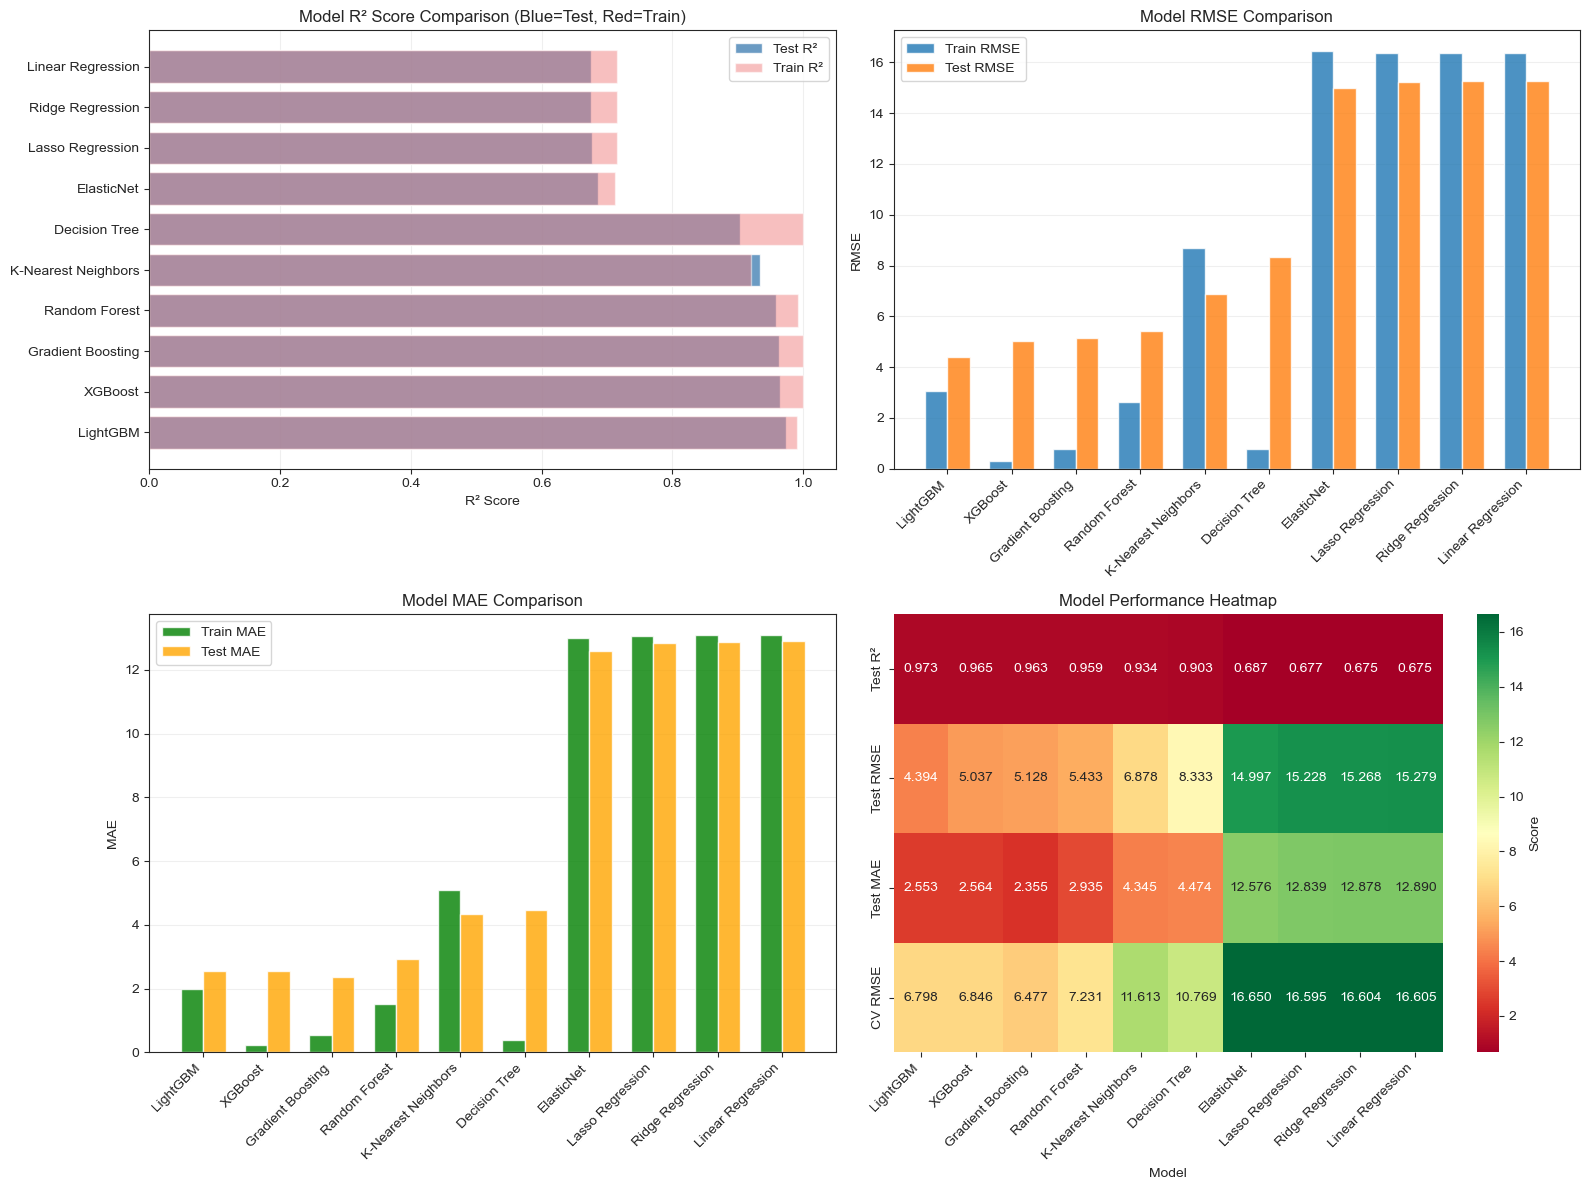

Model comparison visualization saved to 'model_comparison_visualization.png'


In [10]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. R² Score Comparison
x_pos = np.arange(len(results_df))
axes[0, 0].barh(x_pos, results_df['Test R²'], color='steelblue', alpha=0.8)
axes[0, 0].barh(x_pos, results_df['Train R²'], color='lightcoral', alpha=0.5)
axes[0, 0].set_yticks(x_pos)
axes[0, 0].set_yticklabels(results_df['Model'])
axes[0, 0].set_xlabel('R² Score')
axes[0, 0].set_title('Model R² Score Comparison (Blue=Test, Red=Train)')
axes[0, 0].legend(['Test R²', 'Train R²'])
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. RMSE Comparison
width = 0.35
axes[0, 1].bar(x_pos - width/2, results_df['Train RMSE'], width, label='Train RMSE', alpha=0.8)
axes[0, 1].bar(x_pos + width/2, results_df['Test RMSE'], width, label='Test RMSE', alpha=0.8)
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('Model RMSE Comparison')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. MAE Comparison
axes[1, 0].bar(x_pos - width/2, results_df['Train MAE'], width, label='Train MAE', alpha=0.8, color='green')
axes[1, 0].bar(x_pos + width/2, results_df['Test MAE'], width, label='Test MAE', alpha=0.8, color='orange')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_title('Model MAE Comparison')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Overall Performance Heatmap
heatmap_data = results_df[['Test R²', 'Test RMSE', 'Test MAE', 'CV RMSE']].T
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn',
            xticklabels=results_df['Model'], ax=axes[1, 1], cbar_kws={'label': 'Score'})
axes[1, 1].set_title('Model Performance Heatmap')
axes[1, 1].set_xlabel('Model')
plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('model_comparison_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Model comparison visualization saved to 'model_comparison_visualization.png'")

## Best Model Analysis and Predictions

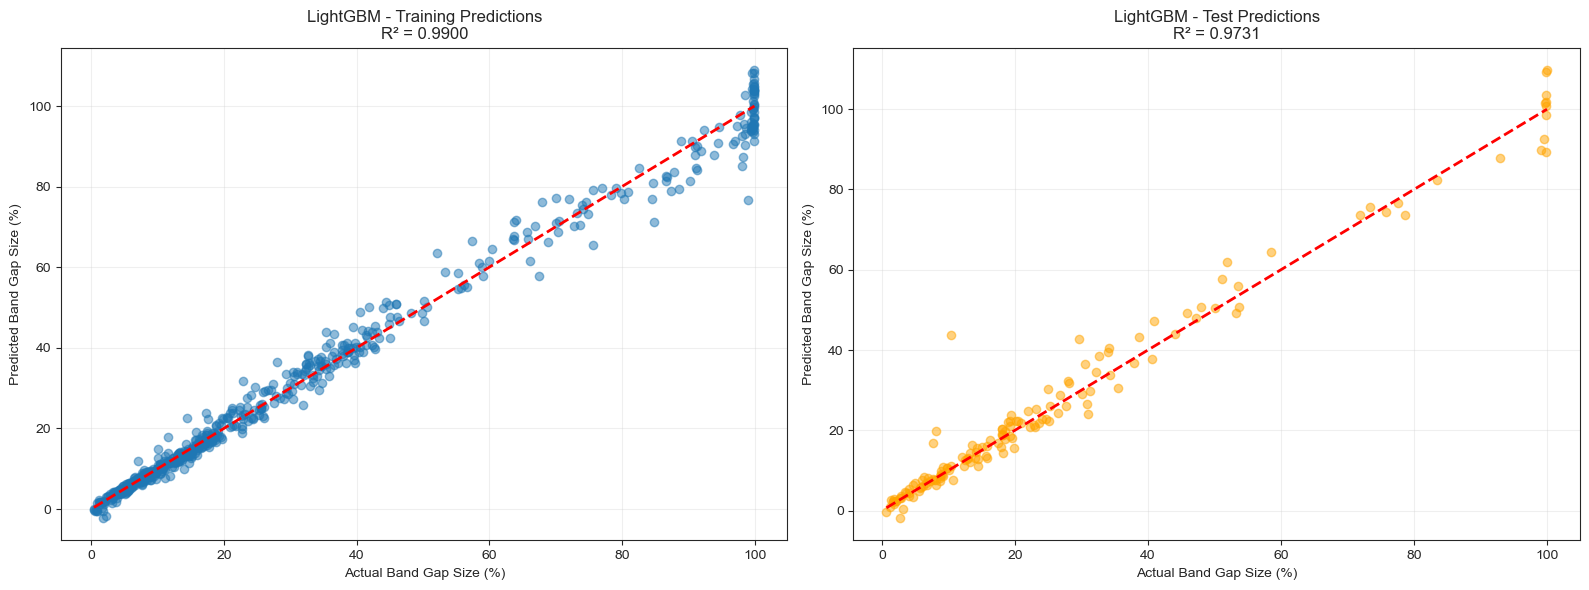

Best model predictions visualization saved to 'best_model_predictions.png'


In [11]:
# Train best model and analyze predictions
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)

# Get predictions
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

# Create prediction plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training predictions
axes[0].scatter(y_train, y_pred_train, alpha=0.5)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Band Gap Size (%)')
axes[0].set_ylabel('Predicted Band Gap Size (%)')
axes[0].set_title(f'{best_model_name} - Training Predictions\nR² = {r2_score(y_train, y_pred_train):.4f}')
axes[0].grid(alpha=0.3)

# Test predictions
axes[1].scatter(y_test, y_pred_test, alpha=0.5, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Band Gap Size (%)')
axes[1].set_ylabel('Predicted Band Gap Size (%)')
axes[1].set_title(f'{best_model_name} - Test Predictions\nR² = {r2_score(y_test, y_pred_test):.4f}')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('best_model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Best model predictions visualization saved to 'best_model_predictions.png'")

## Feature Importance Analysis (for tree-based models)


Feature Importance:
       Feature  Importance
  service_rate         438
  arrival_rate         371
   num_servers         284
queue_capacity          37


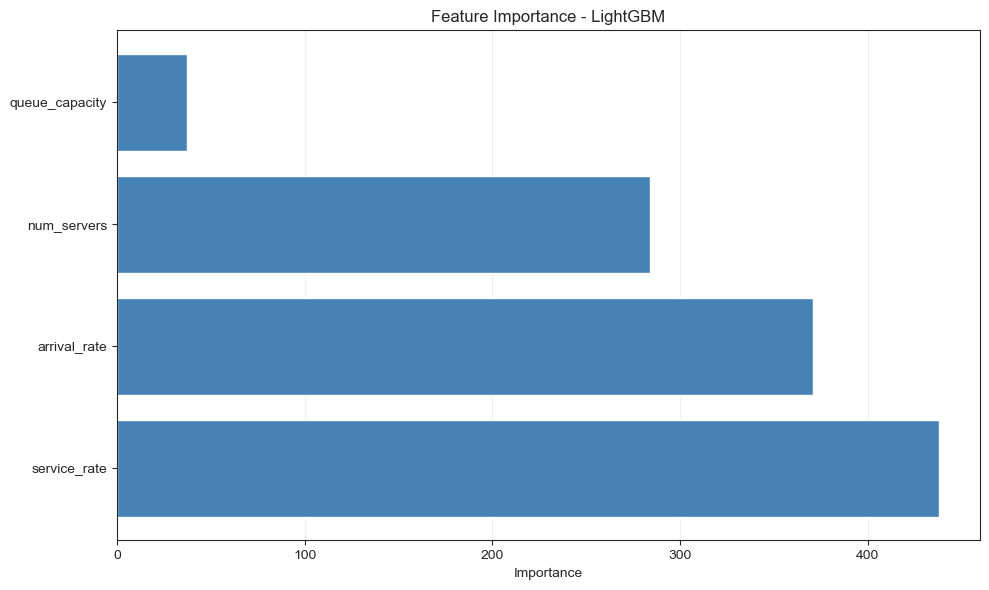


Feature importance visualization saved to 'feature_importance.png'


In [12]:
# Check if best model has feature_importances_ attribute
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nFeature Importance:")
    print("="*40)
    print(feature_importance.to_string(index=False))

    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
    plt.xlabel('Importance')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\nFeature importance visualization saved to 'feature_importance.png'")
else:
    print(f"\nFeature importance not available for {best_model_name}")

## Summary and Conclusions

In [13]:
print("\\n" + "="*100)
print(" "*40 + "FINAL SUMMARY")
print("="*100)

print("\\n1. DATASET STATISTICS:")
print(f"   - Total simulations: {len(df)}")
print(f"   - Average system utilization: {df['utilization'].mean():.2f}%")
print(f"   - Average wait time: {df['avg_wait_time'].mean():.4f}")
print(f"   - Average throughput: {df['throughput'].mean():.4f}")

print("\\n2. PARAMETER RANGES EXPLORED:")
for col in feature_columns:
    print(f"   - {col}: [{df[col].min():.4f}, {df[col].max():.4f}]")

print("\\n3. MODEL PERFORMANCE:")
print(f"   - Best Model: {best_model_name}")
print(f"   - Test R² Score: {best_model_r2:.4f}")
print(f"   - Test RMSE: {best_model_rmse:.4f}")
print(f"   - Test MAE: {results_df.iloc[0]['Test MAE']:.4f}")

print("\\n4. TOP 3 MODELS:")
for i in range(min(3, len(results_df))):
    print(f"   {i+1}. {results_df.iloc[i]['Model']}: R² = {results_df.iloc[i]['Test R²']:.4f}")

print("\\n5. KEY FINDINGS:")
corr_with_target = df[feature_columns + [target_column]].corr()[target_column].drop(target_column).abs().sort_values(ascending=False)
print("   Most influential parameters (by correlation):")
for param, corr in corr_with_target.items():
    print(f"   - {param}: {corr:.4f}")

print("\\n" + "="*100)
print("\\n✅ All tasks completed successfully!")
print("\\nGenerated files:")
print("   1. simpy_simulation_data.csv - Raw simulation data")
print("   2. model_comparison_results.csv - Model performance metrics")
print("   3. data_exploration.png - Data visualization")
print("   4. model_comparison_visualization.png - Model comparison charts")
print("   5. best_model_predictions.png - Best model prediction plots")
if hasattr(best_model, 'feature_importances_'):
    print("   6. feature_importance.png - Feature importance chart")
print("="*100)

\n====================================================================================================
                                        FINAL SUMMARY
\n1. DATASET STATISTICS:
   - Total simulations: 750
   - Average system utilization: 30.63%
   - Average wait time: 0.4570
   - Average throughput: 9.2569
\n2. PARAMETER RANGES EXPLORED:
   - arrival_rate: [0.8319, 17.9584]
   - service_rate: [0.6219, 21.9925]
   - num_servers: [1.0000, 10.0000]
   - queue_capacity: [5.0000, 60.0000]
\n3. MODEL PERFORMANCE:
   - Best Model: LightGBM
   - Test R² Score: 0.9731
   - Test RMSE: 4.3945
   - Test MAE: 2.5531
\n4. TOP 3 MODELS:
   1. LightGBM: R² = 0.9731
   2. XGBoost: R² = 0.9647
   3. Gradient Boosting: R² = 0.9634
\n5. KEY FINDINGS:
   Most influential parameters (by correlation):
   - service_rate: 0.5146
   - num_servers: 0.4616
   - arrival_rate: 0.3923
   - queue_capacity: 0.0281
\n==================================================================================================